In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from profanity_check import predict, predict_prob
import spacy

In [2]:
csvdtf = pd.read_csv("cleaned_training.csv")
csvdtf = csvdtf.reset_index(drop = True)
csvdtf = csvdtf.drop("Unnamed: 0", axis = 1)
csvdtf.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,167663.000000,167663.000000,167663.000000,167663.000000,167663.000000,167663.000000
mean,0.095591,0.009782,0.052999,0.003036,0.049403,0.008947
std,0.294030,0.098417,0.224032,0.055015,0.216708,0.094162
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
## selecting the first 70000 comments to do exploratory data analysis on

csvdtf = csvdtf.iloc[:70000]

csvdtf = csvdtf.reset_index(drop = True)
csvdtf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             70000 non-null  object
 1   comment_text   70000 non-null  object
 2   toxic          70000 non-null  int64 
 3   severe_toxic   70000 non-null  int64 
 4   obscene        70000 non-null  int64 
 5   threat         70000 non-null  int64 
 6   insult         70000 non-null  int64 
 7   identity_hate  70000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 4.3+ MB


In [4]:
sample_size = 70000

In [9]:
import string
## splitting the comments into individual sentences

## making a list where each item is the entire string of each entry's comments
all_sentences = []

for word in csvdtf['comment_text']:
    all_sentences.append(word) 

## forming a new list where each item is a list of words that are in that comment
lines = list()
for line in all_sentences:    
    words = line.split()
    word_list = []
    for w in words:
        word_list.append(w)
    lines.append(word_list)
    

## now, to remove punctuation
stem = []
punct = string.punctuation
for entry in lines:
    innerentry = []
    for word in entry:
        for c in punct:
            if c in word:
                word = word.replace(c, "")
        innerentry.append(word)
    stem.append(innerentry)
  

  
## taking away stop words
from nltk.corpus import stopwords
import spacy
from spacy import displacy
import en_core_web_sm
nlp = en_core_web_sm.load()

stem2 = []

for entry in stem:
    innerstop = []
    for word in entry:   
        if word.lower() not in nlp.Defaults.stop_words and len(word) > 0:
            innerstop.append(word.lower())
    stem2.append(innerstop)

from nltk.stem.snowball import SnowballStemmer
# passing language param of english
s_stemmer = SnowballStemmer(language='english')
stem3 = []
for entry in stem2:
    innerstem = []
    for word in entry:
        if len(word) > 0:
            innerstem.append(s_stemmer.stem(word))
    stem3.append(innerstem)

## these different stages of processing the comments will come in handy at different times
csvdtf["puncted"] = stem
csvdtf["stopworded"] = stem2
csvdtf["stemmed"] = stem3

for comment in csvdtf["stopworded"]:
    for word in comment:
        if len(word) == 0:
            comment.remove(word)

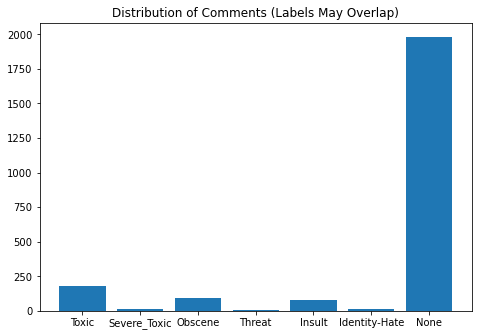

In [12]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
types = ["Toxic", "Severe_Toxic", "Obscene", "Threat", "Insult", "Identity-Hate", "None"]
tox = 0
sev = 0
obs = 0
trt = 0
ins = 0
idhate = 0
none = 0
for x in range(0, sample_size):
    if csvdtf["toxic"][x] == 1:
        tox+=1
    if csvdtf["severe_toxic"][x] == 1:
        sev+=1
    if csvdtf["obscene"][x] == 1:
        obs+=1
    if csvdtf["threat"][x] == 1:
        trt+=1
    if csvdtf["insult"][x] == 1:
        ins+=1
    if csvdtf["identity_hate"][x] == 1:
        idhate+=1
    else:
        none+=1

distrib = [tox, sev, obs, trt, ins, idhate, none]
ax.bar(types, distrib)
ax.set_title("Distribution of Comments (Labels May Overlap)")
plt.show()

[[-0.2463381 ]
 [-0.5059609 ]
 [-0.25632359]
 ...
 [ 0.03325568]
 [-0.6457578 ]
 [-0.5059609 ]]


Text(0.5, 1.0, 'Word Count Distribution')

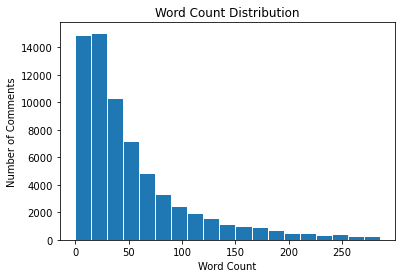

In [11]:
word_count = csvdtf["puncted"].apply(lambda x: len(x))

## standard scaling the feature so that its weights are treated the same way as other features from [0, 1]
from sklearn.preprocessing import StandardScaler
standard = StandardScaler()

scl_wc = []
for num in range(0,sample_size):
    lst = []
    lst.append(word_count[num])
    scl_wc.append(lst)

scaled_word_count = standard.fit_transform(scl_wc)

print(scaled_word_count)

normal_arr_wc = []
for num in range(0, sample_size):
    x = float(scaled_word_count[num])
    normal_arr_wc.append(x)

csvdtf["scaled_word_count"] = normal_arr_wc

plt.hist(word_count, bins = range(0, 300, 15), edgecolor = 'white')
plt.ylabel('Number of Comments')
plt.xlabel('Word Count')
plt.title('Word Count Distribution')



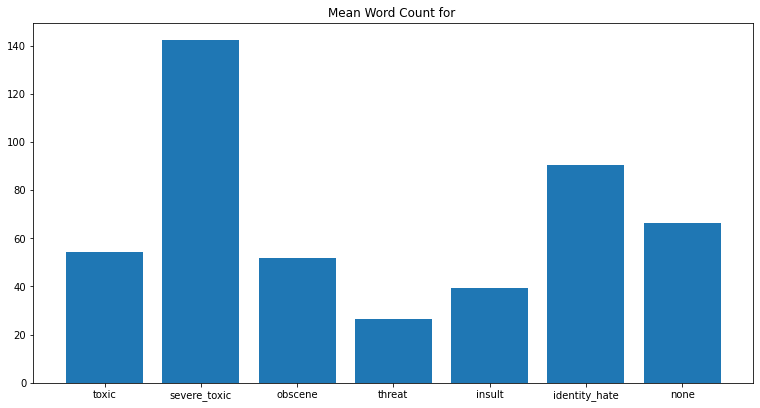

In [14]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
means = []
for x in range(0,6):
    total = 0
    for y in range(0, sample_size):
        if csvdtf[labels[x]][y] == 1:
            total+=len(csvdtf['puncted'][y])
    means.append(float(total)/distrib[x])

labels.append("none")

total = 0
count = 0
for y in range(0, sample_size):
    isNone = True
    for a in range(0,6):
        if csvdtf[labels[a]][y] == 1:
            isNone = False
    if isNone:
        total+=len(csvdtf['puncted'][y])
        count+=1
means.append(float(total)/count)

fig = plt.figure(figsize = (10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(labels, means)
ax.set_title("Mean Word Count for ")
plt.show()

Top 15 Words in  toxic  Comments


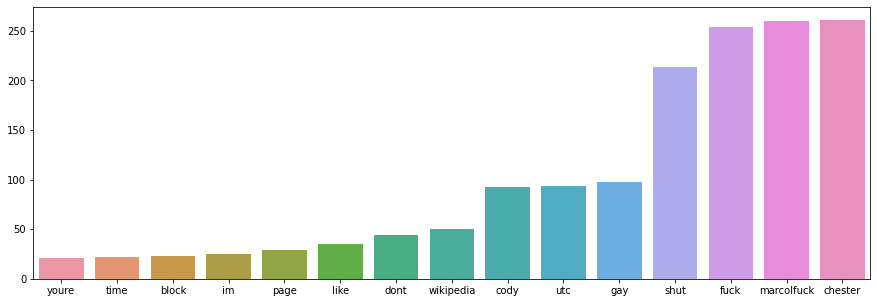

Top 15 Words in  severe_toxic  Comments


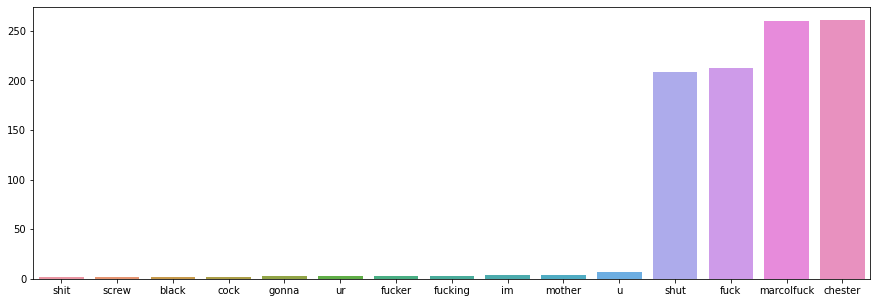

Top 15 Words in  obscene  Comments


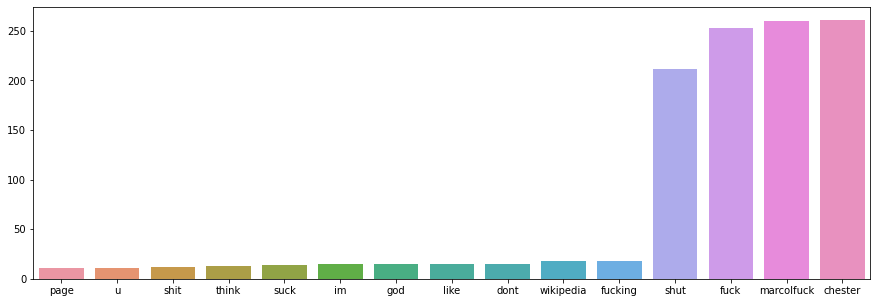

Top 15 Words in  threat  Comments


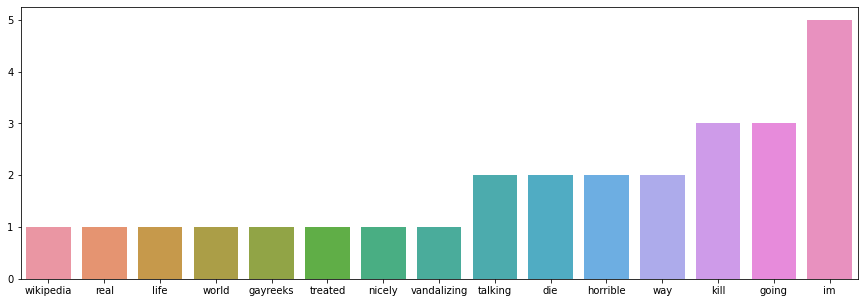

Top 15 Words in  insult  Comments


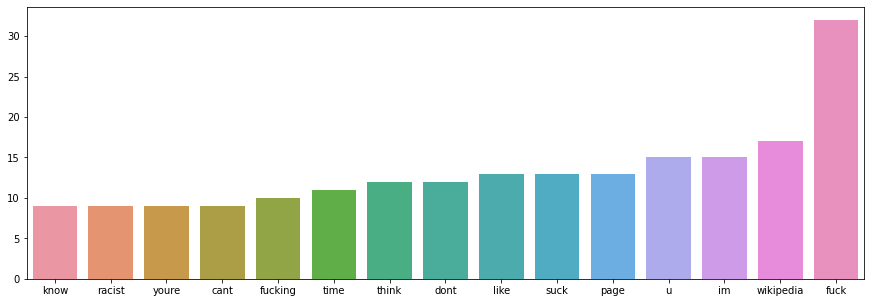

Top 15 Words in  identity_hate  Comments


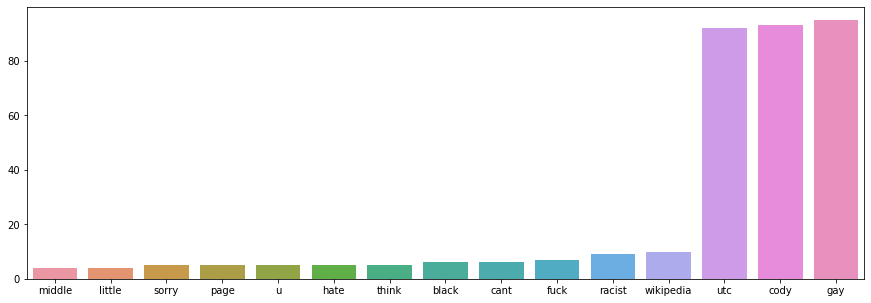

In [18]:
from nltk.probability import FreqDist

def top15words(label):
    frqdist = FreqDist()
    for x in range(0, sample_size):
        if csvdtf[label][x] == 1:
            for word in csvdtf["stopworded"][x]:
                frqdist[word] += 1
    frqsrs = pd.Series(dict(frqdist))
    frqsrs = frqsrs.sort_values()
    
    print("Top 15 Words in ", label, " Comments")

    frqsrs15 = frqsrs[-15:]
    fig, ax = plt.subplots(figsize = (15, 5))
    frqsrs15plt = sns.barplot(x = frqsrs15.index, y = frqsrs15.values, ax = ax)
    plt.show()

labels.remove("none")
for label in labels:
    top15words(label)

Top 15 Words in Nontoxic Comments


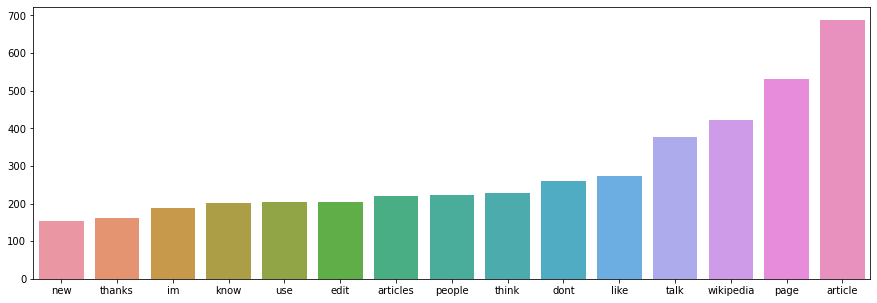

In [20]:
from nltk.probability import FreqDist
## for nonToxic Comments
frqnontoxic = FreqDist()
for x in range(0, sample_size):
    if csvdtf["toxic"][x] == 0:
        for word in csvdtf["stopworded"][x]:
            frqnontoxic[word] += 1
        
frqnontoxic = pd.Series(dict(frqnontoxic))
frqnontoxic = frqnontoxic.sort_values()

print("Top 15 Words in Nontoxic Comments")

frqnontoxic15 = frqnontoxic[-15:]
fig, ax = plt.subplots(figsize = (15, 5))
frqnontoxic15plot = sns.barplot(x = frqnontoxic15.index, y = frqnontoxic15.values, ax = ax)
plt.show()

In [13]:
def plotfeature(feature):
    labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    counts = [0, 0, 0, 0, 0, 0]
    means = []
    totalnontoxic = 0
    countnontoxic = 0
    for x in range(0,6):
        total = 0
        for y in range(0, sample_size):
            if csvdtf[labels[x]][y] == 1:
                total+=csvdtf[feature][y]
                counts[x] += 1
            if csvdtf["toxic"][y] == 0:
                totalnontoxic+=csvdtf[feature][y]
                countnontoxic+=1
        means.append(float(total)/counts[x])

    labels.append("nontoxic")
    means.append(float(totalnontoxic)/countnontoxic)

    fig = plt.figure(figsize = (10,5))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(labels, means)
    ax.set_title(f'Mean {feature} for ')
    plt.show()

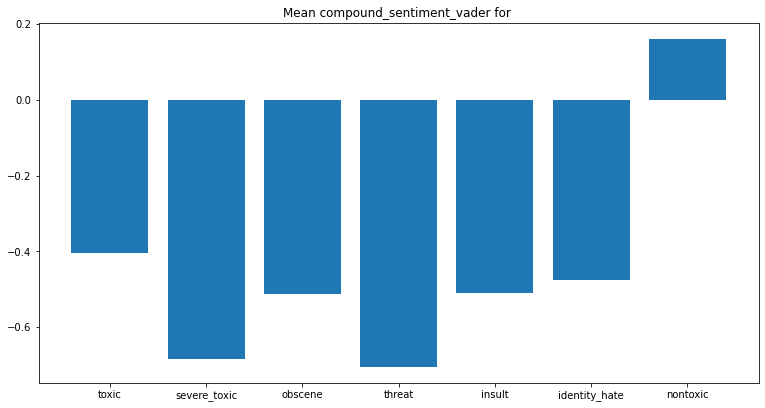

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
## to analyze the sentiments
## when using vader, no need to clean up punctuation
## vader utilizes capitalization, exclamation marks, repitition, emojis (well suited for social media)
compound_sentiment = []
for comment in csvdtf['comment_text']:
    compound_sentiment.append(vader.polarity_scores(comment).get('compound'))
csvdtf['compound_sentiment_vader'] = compound_sentiment
plotfeature('compound_sentiment_vader')

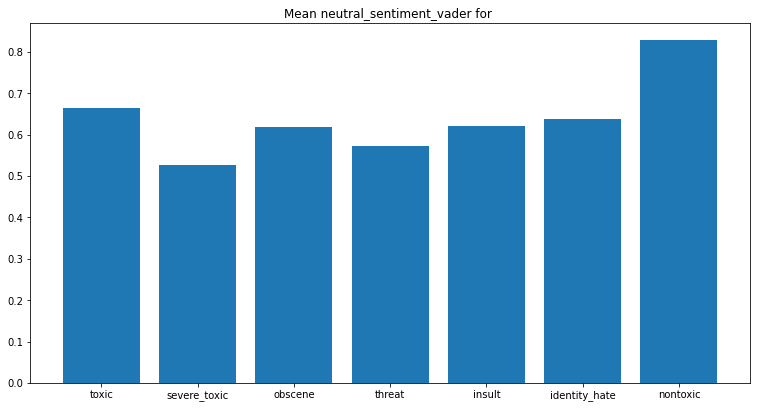

In [15]:
neutral_sentiment = []
for comment in csvdtf['comment_text']:
    neutral_sentiment.append(vader.polarity_scores(comment).get('neu'))
csvdtf['neutral_sentiment_vader'] = neutral_sentiment

plotfeature('neutral_sentiment_vader')

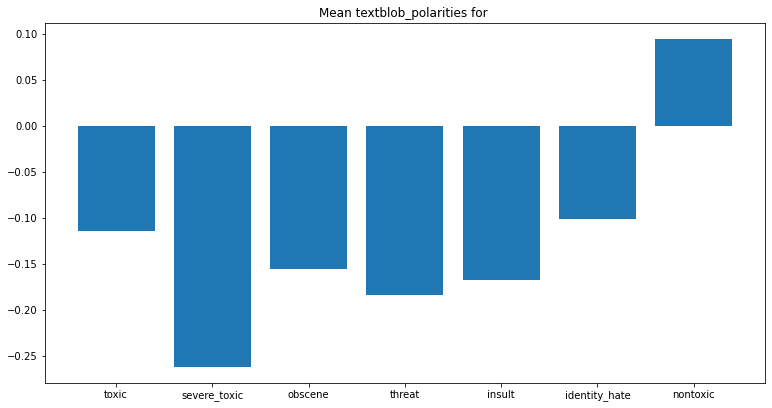

In [16]:
from textblob import TextBlob

polarities = []
for comment in csvdtf['comment_text']:
    polarities.append(TextBlob(comment).sentiment.polarity)

csvdtf['textblob_polarities'] = polarities

plotfeature('textblob_polarities')

In [36]:
## what is with the threat?

polarities = []

for y in range(0, sample_size):
    if csvdtf["threat"][y] == 1:
        polarities.append(csvdtf["textblob_polarities"][y])

print(polarities)

## my guess is that there's a lot of words in a few comments so the cursory sentiment scores may get thrown off by
## the overall nonsense

[0.5, 0.4, -0.03181818181818183, -0.63, 0.0]


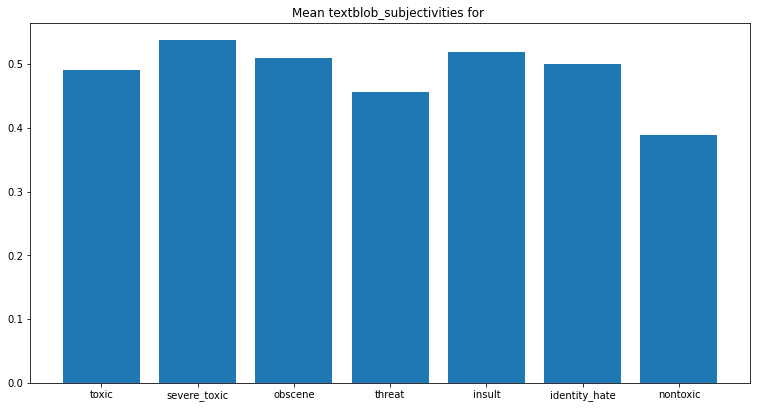

In [17]:
subjectivities = []
for comment in csvdtf['comment_text']:
    subjectivities.append(TextBlob(comment).sentiment.subjectivity)

csvdtf['textblob_subjectivities'] = subjectivities

plotfeature('textblob_subjectivities')

In [18]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")
model = AutoModel.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")
model = SentenceTransformer('bert-base-nli-mean-tokens')
embeds = []
for comment in csvdtf["comment_text"]:
    embeds.append(model.encode(comment))

columnswise = []
for x in range(0, len(embeds[0])):
    column = []
    for y in range(0, sample_size):
        column.append(embeds[y][x])
    columnswise.append(column)

for z in range(0, len(embeds[0])):
    csvdtf["bert_feature_" + str(z)] = columnswise[z]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at /Users/ritubelani/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
# import
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import warnings
warnings.filterwarnings('ignore')
lower = []
for comment in csvdtf["puncted"]:
    sentences = []
    for sentence in comment:
        sentences.append(sentence.lower())
    lower.append(sentences)
csvdtf["lower_puncted"] = lower

tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(csvdtf["lower_puncted"])]

## Train doc2vec model
model = Doc2Vec(tagged_data, vector_size = 20, window = 2, min_count = 1, epochs = 100)

vectors = []
for comment in csvdtf["lower_puncted"]:
    vectors.append(model.infer_vector(comment))
    

csvdtf["doc2vec_embeds"] = vectors


columnswise = []
for x in range(0, len(vectors[0])):
    column = []
    for y in range(0, sample_size):
        column.append(vectors[y][x])
    columnswise.append(column)

for z in range(0, len(vectors[0])):
    csvdtf["doc2vec_feature_" + str(z)] = columnswise[z]

/Users/ritubelani/opt/anaconda3/envs/SpacyEnv/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [49]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print("module %s loaded" % module_url)

all_comments = []

for comment in csvdtf["comment_text"]:
    all_comments.append(comment)

sentence_embeddings = model(all_comments)

csvdtf["universal_sentence_encoder"] = sentence_embeddings

columnswise = []
for x in range(0, len(sentence_embeddings[0])):
    column = []
    for y in range(0, sample_size):
        column.append(sentence_embeddings[y][x].numpy())
    columnswise.append(column)

for z in range(0, len(sentence_embeddings[0])):
    csvdtf["use_feature_" + str(z)] = columnswise[z]

In [43]:
probs = []
for c in range(0, sample_size):
    slist = []
    slist.append(all_sentences[c])
    probability = predict_prob(slist)
    probs.append(float(probability))

csvdtf["profanity_probability"] = probs

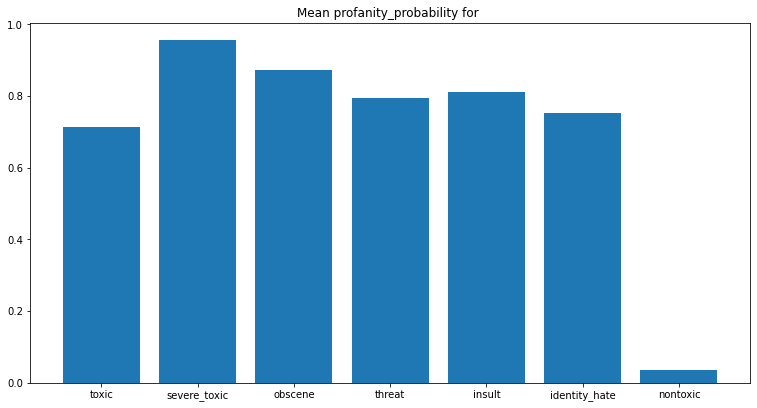

In [44]:
plotfeature('profanity_probability')

In [ ]:
csvdtf.to_csv("FeaturesAsOf6_12.csv")

In [5]:
## continuing the featurization later on
csvdtf = pd.read_csv("FeaturesAsOf6_12.csv")

import language_tool_python
tool = language_tool_python.LanguageTool("en-US")
lengts = []
for comment in csvdtf["stopworded"]:
    f = []
    f.append(len(tool.check(comment)))
    lengts.append(f)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(lengts)
scaledlengts = scaler.transform(lengts)

In [8]:
markers = []
for word in open("ists_isms"):
    if "\n" in word:
        markers.append(word[:len(word)-1])
    else:
        markers.append(word)
        
counts = []
for comment in csvdtf["stopworded"]:
    x = 0
    for word in markers:
        if word in comment:
            x = 1
    counts.append(x)

csvdtf["ist_present"] = counts